# Code for anyalysing Circular Dichroism data

This code executes data parsing for CD signal (mdeg) as a function of wavelength (nm).

## What this notebook includes

- Parsing raw CD TXT files into dataframes
- Transforming CD signal to MRE
- Visualisation of CD spectrum and variable temperature data
- Estimation of transition temperatures

## What this notebook does not include

- Secondary structure deconvolution

## Todo

- [ ] Save out transformed and tidied data
- [ ] Plot melt data
- [ ] Fit melt data and estimate TM
- [ ] Allow for multiple files
- [ ] Batch mode?
- [ ] Connect to GitHub

In [129]:
#@title # Setup


#@markdown This cell import all the necessary code required from other modules
#@markdown and defines custom functions.

#@markdown **RUN THIS FIRST!**

# standard
import re
from pathlib import Path

# external
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from google.colab import drive
drive.mount('/content/drive')

# custom functions
def parse_data(
        dataPath:Path,
        absorbanceChannel:bool,
        numAmides:int,
        protConc:float,
        pathLength:float
    ) -> pd.DataFrame:

    dataStr = dataPath.read_text()
    dataPattern = re.compile("XYDATA\n(.*?)\n##### Extended Information", re.DOTALL)
    dataMatch = re.search(dataPattern, dataStr).group(1)

    dataDict = {
        "file_name":dataPath.stem,
        "wavelength_nm": [],
        "cd_mdeg": [],
        "ht_v": [],
    }

    if absorbanceChannel:
        dataDict["absorbance_au"] = []

    for line in dataMatch.splitlines():

        line_split = line.split("\t")
        dataDict["wavelength_nm"].append(float(line_split[0]))
        dataDict["cd_mdeg"].append(float(line_split[1]))
        dataDict["ht_v"].append(float(line_split[2]))

        if absorbanceChannel:
            dataDict["absorbance_au"].append(float(line_split[3]))

    dataDict["num_amides"] = numAmides
    dataDict["conc_M"] = protConc
    dataDict["pathlength_cm"] = pathLength

    return pd.DataFrame(dataDict)


def calculate_mre(cd_mdeg_blank, pathlength_cm, num_amides, conc_M):
    """
    Calculate Mean Residue Ellipticity (MRE).

    Formula reference: https://www.photophysics.com/faqs/methods-techniques/cd-units-faqs/
    Units: deg cm^2 dmol^-1 res^-1

    Parameters:
        cd_mdeg_blank (pd.Series): CD signal in millidegrees (after blank correction)
        pathlength_cm (float or pd.Series): Pathlength in cm
        num_amides (int or pd.Series): Number of amide bonds (residues - 1)
        conc_M (float or pd.Series): Concentration in molarity (M)

    Returns:
        pd.Series: MRE values
    """
    # convert millidegrees to degrees
    cd_deg_blank = cd_mdeg_blank / 1000
    mean_residue_concentration = num_amides * conc_M
    return 100 * cd_deg_blank / (pathlength_cm * mean_residue_concentration)

def plotSpectrum(spectrumPlot, spectrumData, data_to_plot:str, showHT:bool):

    if showHT:
        # get the wavelength where HT exceeds 600 V
        highHT = spectrumData.loc[spectrumData["ht_v"] >= 600, "wavelength_nm"].max()

        # denote region of HT > 600 V
        spectrumPlot.axvspan(spectrumData["wavelength_nm"].min(), highHT, facecolor=".8")

    # Plot MRE spectrum
    sns.lineplot(
        data=spectrumData,
        x="wavelength_nm",
        y=data_to_plot,
        ax=spectrumPlot,
        hue="file_name",
        legend=False
    )

    # Set plot aesthetics
    spectrumPlot.set(
        xlim=(spectrumData["wavelength_nm"].min(), spectrumData["wavelength_nm"].max()),
        xlabel="Wavelength (nm)"
    )

    if data_to_plot == "mre":
        spectrumPlot.set_ylabel(r"MRE (deg cm$^2$ / dmol)")

        # Format y-axis
        spectrumPlot.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        spectrumPlot.ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

    else:
        spectrumPlot.set_ylabel("Absorbance (AU)")

def plotTension(tensionPlot, spectrumData):

    # Plot MRE spectrum
    sns.lineplot(
        data=spectrumData,
        x="wavelength_nm",
        y="ht_v",
        ax=tensionPlot,
        hue="file_name",
        legend=False
    )

    # Set plot aesthetics
    tensionPlot.set(
        xlim=(spectrumData["wavelength_nm"].min(), spectrumData["wavelength_nm"].max()),
        xlabel="Wavelength (nm)"
    )

    tensionPlot.set_ylabel("HT (V)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
#@title #I/O

#@markdown - Provide the file path to your baseline file:
blankPath = "" #@param {type:"string"}
#@markdown - Provide the file path to your sample file:
spectrumPath = "" #@param {type:"string"}

#@markdown ## Sample information

#@markdown - How many amides are present (length of sequence - 1, unless chemical modified e.g. Acetyl group):
numAmides =  100 #@param {type:"raw"}

#@markdown - Protein concentration (M):
protConc =  10e-6 #@param {type:"raw"}

#@markdown - Cuvette pathlength (cm):
pathLength =  0.1 #@param {type:"raw"}

#@markdown - Does the data contain an absorbance channel?
absorbanceChannel = True #@param {type:"boolean"}

#@markdown - If you have no data, use example data, mainly for testing.
useExample = True #@param {type:"boolean"}

if useExample:

    numAmides =  168
    protConc = 10e-6
    pathLength = 0.1
    absorbanceChannel = True
    blankPath = Path("/content/drive/MyDrive/scripts_and_software/lab/example_data/cd/20250221_blank_0uM_water_0amides_1mm_20C_PBS_J1500_1.txt")
    spectrumPath = Path("/content/drive/MyDrive/scripts_and_software/lab/example_data/cd/20250221_pre_10uM_Ser_169amides_1mm_20C_PBS_J1500_1.txt")

# parse data
blankData = parse_data(blankPath, absorbanceChannel, 0, 0, pathLength)
spectrumData = parse_data(spectrumPath, absorbanceChannel, numAmides, protConc, pathLength)

# blank baseline from data
spectrumData["cd_mdeg_blank"] = spectrumData["cd_mdeg"] - blankData["cd_mdeg"]

# calculate mre
blankData["mre"] = np.nan
spectrumData['mre'] = calculate_mre(
    spectrumData["cd_mdeg_blank"],
    spectrumData["pathlength_cm"],
    spectrumData["num_amides"],
    spectrumData["conc_M"]
)

allData = pd.concat([blankData, spectrumData], ignore_index=True)
display(allData)

,file_name,wavelength_nm,cd_mdeg,ht_v,absorbance_au,num_amides,conc_M,pathlength_cm,mre,cd_mdeg_blank
0,20250221_blank_0uM_water_0amides_1mm_20C_PBS_J...,260.0,-0.114488,269.638,0.935370,0,0.00000,0.1,NaN,NaN
1,20250221_blank_0uM_water_0amides_1mm_20C_PBS_J...,259.0,-0.124416,269.914,0.938566,0,0.00000,0.1,NaN,NaN
2,20250221_blank_0uM_water_0amides_1mm_20C_PBS_J...,258.0,-0.168665,270.194,0.941791,0,0.00000,0.1,NaN,NaN
3,20250221_blank_0uM_water_0amides_1mm_20C_PBS_J...,257.0,-0.180853,270.527,0.945633,0,0.00000,0.1,NaN,NaN
4,20250221_blank_0uM_water_0amides_1mm_20C_PBS_J...,256.0,-0.164495,270.798,0.948753,0,0.00000,0.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
137,20250221_pre_10uM_Ser_169amides_1mm_20C_PBS_J1...,194.0,-2.355650,1104.480,5.856130,168,0.00001,0.1,-1553.846429,-2.610462
138,20250221_pre_10uM_Ser_169amides_1mm_20C_PBS_J1...,193.0,-3.677300,1104.590,5.856500,168,0.00001,0.1,-2743.342262,-4.608815
139,20250221_pre_10uM_Ser_169amides_1mm_20C_PBS_J1...,192.0,-2.438250,1104.610,5.856600,168,0.00001,0.1,-2948.333333,-4.953200
140,20250221_pre_10uM_Ser_169amides_1mm_20C_PBS_J1...,191.0,-0.149817,1104.650,5.856730,168,0.00001,0.1,-1075.801786,-1.807347


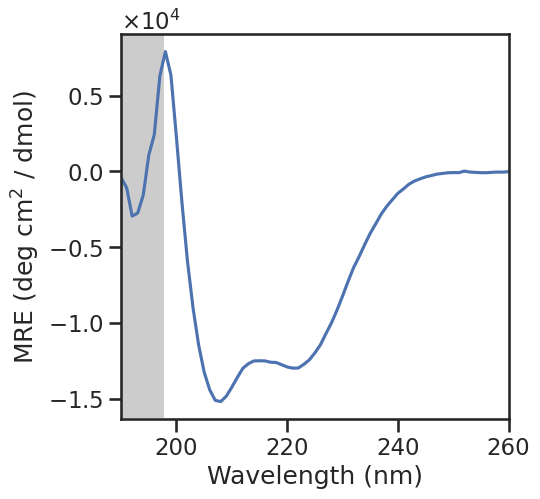

In [134]:
#@title # Visualisation options

#@markdown - In what context will you be showing this data?
plotContext = "talk" #@param ["paper", "notebook", "talk", "poster"]

#@markdown - What aspect ratio to use for the plots. If you're plotting MRE and absorbance, I would suggest setting to 2.
plotAspect = 1 #@param {type: "raw"}

#@markdown - Show HT as seperate plot, else high HT regions are denoted by greyed region.
plotHT = False #@param {type:"boolean"}

#@markdown - Show Absorbance as seperate plot.
plotAbsorbance = False #@param {type:"boolean"}

#@markdown Feel free to play around with the code to get the plots how you like them!

#@title Data visualisation

plotHeights = {
    "paper": 3,
    "notebook": 4,
    "talk": 5,
    "poster": 7,
}

sns.set(style="ticks", context=plotContext, rc={"figure.figsize":[plotHeights[plotContext] * plotAspect, plotHeights[plotContext]]})

if plotHT and plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((5,2), (0,0), rowspan=4)
    absPlot = plt.subplot2grid((5,2), (0,1), rowspan=4)
    mre_htPlot = plt.subplot2grid((5,2), (4,0))
    abs_htPlot = plt.subplot2grid((5,2), (4,1))

    # make base plots
    plotSpectrum(mrePlot, spectrumData, "mre", showHT=False)
    plotSpectrum(absPlot, spectrumData, "absorbance_au", showHT=False)
    plotTension(mre_htPlot, spectrumData)
    plotTension(abs_htPlot, spectrumData)

    # remove unnessacary labels
    mrePlot.set(xlabel="", xticklabels=[])
    absPlot.set(xlabel="", xticklabels=[])

    plt.tight_layout()

elif plotHT and not plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((5,1), (0,0), rowspan=4)
    mre_htPlot = plt.subplot2grid((5,1), (4,0))

    # make base plots
    plotSpectrum(mrePlot, spectrumData, "mre", showHT=False)
    plotTension(mre_htPlot, spectrumData)

    # remove unnessacary labels
    mrePlot.set(xlabel="", xticklabels=[])

    plt.tight_layout()

elif plotAbsorbance:

    # setup plot grid
    mrePlot = plt.subplot2grid((1,2), (0,0))
    absPlot = plt.subplot2grid((1,2), (0,1))

    # make base plots
    plotSpectrum(mrePlot, spectrumData, "mre", showHT=True)
    plotSpectrum(absPlot, spectrumData, "absorbance_au", showHT=True)

    plt.tight_layout()

else:

    # setup plot grid
    mrePlot = plt.subplot2grid((1,1), (0,0))

    # make base plot
    plotSpectrum(mrePlot, spectrumData, "mre", showHT=True)


plt.show()


